### PIRYAM DATA LOADER

In [2]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

class CaptchaDatasetRGB(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Direct path to the specific data folder (train, val, or test)
                               e.g., '/path/to/UTN-CV25-Captcha-Dataset/part2/train'
            transform (callable, optional): Optional transform to be applied on images
        """
        self.data_dir = data_dir
        self.images_dir = os.path.join(self.data_dir, 'images')
        self.transform = transform
        self.image_list = sorted([f for f in os.listdir(self.images_dir) if f.endswith('.png')])
        
        # Load labels if available
        self.labels_dict = {}
        labels_file = os.path.join(self.data_dir, 'labels.json')
        if os.path.exists(labels_file):
            with open(labels_file, 'r') as f:
                labels = json.load(f)
                # Create a dictionary for faster lookup by image_id
                self.labels_dict = {item['image_id']: item for item in labels}
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.image_list[idx]
        img_path = os.path.join(self.images_dir, img_name)
        
        # Load image as RGB
        image = Image.open(img_path).convert('RGB')  # Convert to RGB instead of 'L'
        
        # Get image_id without extension
        image_id = os.path.splitext(img_name)[0]
        
        # Get labels if available
        label_info = self.labels_dict.get(image_id, {})
        
        # Extract captcha string and bounding boxes
        captcha_string = label_info.get('captcha_string', '')
        annotations = label_info.get('annotations', [])
        
        # Apply transforms if specified
        if self.transform:
            image = self.transform(image)
        
        sample = {
            'image': image,
            'image_id': image_id,
            'captcha_string': captcha_string,
            'annotations': annotations
        }
        
        return sample

# Custom collate function for RGB images
def custom_collate_fn_rgb(batch):
    """Custom collate function to handle variable-length annotations for RGB images"""
    images = torch.stack([item['image'] for item in batch])
    image_ids = [item['image_id'] for item in batch]
    captcha_strings = [item['captcha_string'] for item in batch]
    annotations = [item['annotations'] for item in batch]  # Keep as list of lists
    
    return {
        'image': images,
        'image_id': image_ids,
        'captcha_string': captcha_strings,
        'annotations': annotations
    }

# Helper function to create RGB dataloaders
def get_dataloader_rgb(data_folder, batch_size=32, shuffle=True):
    """
    Args:
        data_folder (string): Direct path to specific data folder
                            e.g. '/path/to/UTN-CV25-Captcha-Dataset/part2/train'
        batch_size (int): Batch size for the dataloader
        shuffle (bool): Whether to shuffle the data
    """
    # Define transformations for RGB images
    transform = transforms.Compose([
        # transforms.Resize((160, 640)),  # Keep original size
        transforms.ToTensor(),         # Convert to tensor [0, 1]
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5],     # RGB channels normalization to [-1, 1]
            std=[0.5, 0.5, 0.5]
        )
    ])
    
    # Create dataset
    dataset = CaptchaDatasetRGB(
        data_dir=data_folder,
        transform=transform
    )
    
    # Create dataloader with custom collate function
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,
        collate_fn=custom_collate_fn_rgb
    )
    
    return dataloader

# Example usage and visualization
def visualize_rgb_sample(batch):
    """Visualize RGB CAPTCHA sample"""
    # Get first image in batch
    img = batch['image'][0]  # Shape: [3, 160, 640]
    
    # Denormalize from [-1, 1] to [0, 1]
    img = img * 0.5 + 0.5
    
    # Convert from [C, H, W] to [H, W, C] for matplotlib
    img = img.permute(1, 2, 0)
    
    plt.figure(figsize=(12, 4))
    plt.imshow(img)
    plt.title(f"RGB CAPTCHA: {batch['captcha_string'][0]}")
    plt.axis('off')
    plt.show()
    
    print(f"Image shape: {batch['image'].shape}")  # Should be [batch_size, 3, 160, 640]
    print(f"Image value range: [{batch['image'].min():.3f}, {batch['image'].max():.3f}]")

RGB Training samples: 60000
RGB Validation samples: 20000
RGB Test samples: 20000


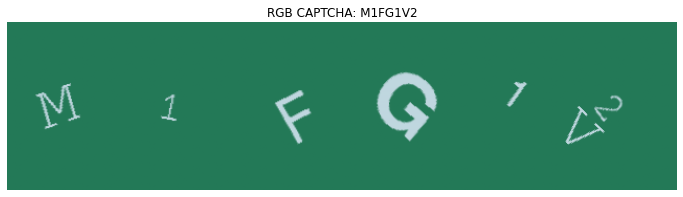

Image shape: torch.Size([32, 3, 160, 640])
Image value range: [-0.992, 0.984]
Number of annotations for first image: 7


In [3]:
import os

# Base path to the dataset
base_path = '/home/utn/abap44us/Downloads/UTN-CV25-Captcha-Dataset/part2'

# Create RGB dataloaders for each split
train_loader_rgb = get_dataloader_rgb(os.path.join(base_path, 'train'), batch_size=32, shuffle=True)
val_loader_rgb = get_dataloader_rgb(os.path.join(base_path, 'val'), batch_size=32, shuffle=False)
test_loader_rgb = get_dataloader_rgb(os.path.join(base_path, 'test'), batch_size=32, shuffle=False)

# Print dataset sizes
print(f"RGB Training samples: {len(train_loader_rgb.dataset)}")
print(f"RGB Validation samples: {len(val_loader_rgb.dataset)}")
print(f"RGB Test samples: {len(test_loader_rgb.dataset)}")

# Display a sample RGB image
for batch in train_loader_rgb:
    visualize_rgb_sample(batch)
    print(f"Number of annotations for first image: {len(batch['annotations'][0])}")
    break

### NOAS IMPROVED RESNER 18

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- Stem ----------
class Stem(nn.Module):
    """ResNet stem: 7x7 s2 + BN + ReLU + 3x3 MaxPool s2."""
    def __init__(self, in_ch=3, out_ch=64):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Kaiming init for the conv
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.bn.weight, 1.0)
        nn.init.constant_(self.bn.bias, 0.0)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x  # e.g., 640x160 -> 160x40


# ---------- Basic Residual Block ----------
class ResidualBlock(nn.Module):
    expansion = 1
    def __init__(self, in_ch, out_ch, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.downsample = downsample  # 1x1 conv + BN when shape changes

        # Init
        for m in (self.conv1, self.conv2):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.bn1.weight, 1.0); nn.init.constant_(self.bn1.bias, 0.0)
        nn.init.constant_(self.bn2.weight, 1.0); nn.init.constant_(self.bn2.bias, 0.0)

    def forward(self, x):
        identity = x

        out = self.conv1(x); out = self.bn1(out); out = self.relu(out)
        out = self.conv2(out); out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


# ---------- ResNet-18 Backbone ----------
class ResNet18Backbone(nn.Module):
    """
    Backbone only (no GAP/FC). For 640x160 input:
      stem -> 160x40
      layer2 -> 80x20
      layer3 -> 40x10
      layer4 -> 20x5   (512 channels)  <-- feed this to your YOLO head
    If return_p3=True, also returns the 40x10 map for a higher-res head.
    """
    def __init__(self, in_ch=3, return_p3=False):
        super().__init__()
        self.stem = Stem(in_ch=in_ch, out_ch=64)
        self.in_ch = 64

        self.layer1 = self._make_layer(ResidualBlock, 64,  blocks=2, stride=1)  # 160x40
        self.layer2 = self._make_layer(ResidualBlock, 128, blocks=2, stride=2)  #  80x20
        self.layer3 = self._make_layer(ResidualBlock, 256, blocks=2, stride=2)  #  40x10
        self.layer4 = self._make_layer(ResidualBlock, 512, blocks=2, stride=2)  #  20x5

        self.return_p3 = return_p3

    def _make_layer(self, block, out_ch, blocks, stride):
        down = None
        if stride != 1 or self.in_ch != out_ch:
            down = nn.Sequential(
                nn.Conv2d(self.in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )

        layers = [block(self.in_ch, out_ch, stride=stride, downsample=down)]
        self.in_ch = out_ch
        for _ in range(1, blocks):
            layers.append(block(out_ch, out_ch, stride=1, downsample=None))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)         # -> 160x40
        x = self.layer1(x)       # -> 160x40
        x = self.layer2(x)       # ->  80x20
        p3 = self.layer3(x)      # ->  40x10
        p4 = self.layer4(p3)     # ->  20x5
        return (p4, p3) if self.return_p3 else p4


# --- Weight Init with He Init method

def init_weights_kaiming(m):
    """Applies Kaiming initialization to Conv/Linear layers, zeros to biases."""
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)


# ---- quick sanity check ----
if __name__ == "__main__":
    model = ResNet18Backbone(in_ch=3, return_p3=True)
    x = torch.randn(1, 3, 160, 640)  # HxW ordering if you prefer, swap to (B,3,160,640)
    p4, p3 = model(x)
    model.apply(init_weights_kaiming)
    print(p4.shape, p3.shape)  # expect: torch.Size([1, 512, 5, 20]) and [1, 256, 10, 40]


torch.Size([1, 512, 5, 20]) torch.Size([1, 256, 10, 40])


### ResNet18 Improvements w/ Grayscale

Changes:
-input channels reduce to 1 to handle greyscale
- Reduce stem size, but add extra 3 layers of conv. Allows for less image lose too much info from input
- Output Channel is now 256 (vs traditional 512) to keep larger feature map
- p3 and p4 feature maps returned, to create FPN neck

CHAT GPT also provides two layers that are option to add.
- Blur Layer to Downsampling can alias thin strokes into jagged, misleading patterns. Blurring just a bit reduces aliasing while keeping the signal—useful when characters are thin or partially occluded by lines
- Add attention to resblock : key for localization and any head that predicts per-cell outputs (YOLO-style or oriented boxes). Your final maps end up around H/8 × W/8 (≈20×80 for 160×640 input

Apparently  SiLU is better for OCR, still not know why

 



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- (Optional) Lightweight Anti-Alias Downsample ----------
class BlurPool(nn.Module):
    """
    [IMPROVEMENT] Anti-aliased downsampling (a.k.a. BlurPool).
    Goal: preserve thin strokes/edges when reducing resolution.
    """
    def __init__(self, channels, stride=2):
        super().__init__()
        kernel = torch.tensor([[1., 2., 1.],
                               [2., 4., 2.],
                               [1., 2., 1.]]) / 16.0
        self.register_buffer('kernel', kernel[None, None, :, :].repeat(channels, 1, 1, 1))
        self.stride = stride
        self.groups = channels

    def forward(self, x):
        return F.conv2d(x, self.kernel, stride=self.stride, padding=1, groups=self.groups)

# ---------- (Optional) Efficient Channel Attention ----------
class ECA(nn.Module):
    """
    [IMPROVEMENT] ECA attention (cheap channel attention).
    Goal: boost character strokes vs clutter with minimal params/compute.
    """
    def __init__(self, channels, k_size=3):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.conv1d = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size-1)//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg(x)                               # B, C, 1, 1
        y = self.conv1d(y.squeeze(-1).transpose(-1, -2))  # B, 1, C
        y = self.sigmoid(y).transpose(-1, -2).unsqueeze(-1)  # B, C, 1, 1
        return x * y

# ---------- Stem ----------
class Stem(nn.Module):
    """
    Small-image friendly stem.
    Old ResNet stem (kept commented):
        # self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=7, stride=2, padding=3, bias=False)
        # self.bn   = nn.BatchNorm2d(out_ch)
        # self.relu = nn.ReLU(inplace=True)
        # self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    [IMPROVEMENT] Replace 7x7 s2 + maxpool with 3×(3x3) conv stack and delay the first downsample.
    Goal: retain fine glyph details and reduce aliasing on thin strokes.
    """
    # def __init__(self, in_ch=3, out_ch=64):  # (old signature)
    def __init__(self, in_ch=1, out_ch=64):    # [IMPROVEMENT] default to 1-ch for grayscale inputs
        super().__init__()
        # --- Old impl kept for reference ---
        # self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=7, stride=2, padding=3, bias=False)
        # self.bn   = nn.BatchNorm2d(out_ch)
        # self.relu = nn.ReLU(inplace=True)
        # self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # --- New small-image stem ---
        self.conv1 = nn.Conv2d(in_ch, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(32)
        self.act1  = nn.SiLU(inplace=True)  # [IMPROVEMENT] SiLU often helps on OCR edges

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(32)
        self.act2  = nn.SiLU(inplace=True)

        self.conv3 = nn.Conv2d(32, out_ch, kernel_size=3, stride=2, padding=1, bias=False)  # first downsample here
        self.bn3   = nn.BatchNorm2d(out_ch)
        self.act3  = nn.SiLU(inplace=True)

        # Optional light anti-alias after first downsample (comment out to disable)
        # self.blur = BlurPool(out_ch, stride=1)  # stride 1 acts like a gentle blur

        # Init
        for m in [self.conv1, self.conv2, self.conv3]:
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        for b in [self.bn1, self.bn2, self.bn3]:
            nn.init.constant_(b.weight, 1.0)
            nn.init.constant_(b.bias, 0.0)

    def forward(self, x):
        # --- Old forward kept for reference ---
        # x = self.conv(x)
        # x = self.bn(x)
        # x = self.relu(x)
        # x = self.pool(x)
        # return x

        x = self.act1(self.bn1(self.conv1(x)))
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.act3(self.bn3(self.conv3(x)))
        x = self.blur(x)
        return x  # e.g., 160x640 -> 80x320 (if your input is HxW=160x640)

# ---------- Basic Residual Block ----------
class ResidualBlock(nn.Module):
    expansion = 1
    def __init__(self, in_ch, out_ch, stride=1, downsample=None, dilation=1, use_eca=True):
        super().__init__()
        """
        [IMPROVEMENT] (1) allow dilation to keep output stride small (OS=8),
                       (2) switch activations to SiLU,
                       (3) optional ECA for cheap attention.
        Goal: preserve resolution and emphasize strokes without heavy compute.
        """
        padding = dilation
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride,
                               padding=padding, dilation=dilation, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.act   = nn.SiLU(inplace=True)  # was ReLU

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1,
                               padding=padding, dilation=dilation, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.downsample = downsample  # can include BlurPool/AvgPool + 1x1 conv
        self.eca = ECA(out_ch) if use_eca else nn.Identity()

        # Init
        for m in (self.conv1, self.conv2):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.bn1.weight, 1.0); nn.init.constant_(self.bn1.bias, 0.0)
        nn.init.constant_(self.bn2.weight, 1.0); nn.init.constant_(self.bn2.bias, 0.0)

    def forward(self, x):
        identity = x

        out = self.act(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.eca(out)  # [IMPROVEMENT] channel attention

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.act(out)
        return out

# ---------- ResNet-18 Backbone ----------
class ResNet18Backbone(nn.Module):
    """
    Backbone only (no GAP/FC).

    Old spatial scales for 640x160 (W×H) input with vanilla strides:
      stem -> 160x40
      layer2 -> 80x20
      layer3 -> 40x10
      layer4 -> 20x5   (512 ch)

    [IMPROVEMENT] Keep output stride small (OS≈8) using dilation in later stages:
        - layer1: stride 1 (≈1/4 if input after stem is 1/2)
        - layer2: stride 2 (down to 1/8)
        - layer3: stride 1, dilation=2 (stay at 1/8, expand RF)
        - layer4: stride 1, dilation=2 (stay at 1/8, expand RF)
    Goal: better localization of small characters while keeping receptive field.
    """
    def __init__(self, in_ch=1, return_p3=True, use_blurpool=True):
        super().__init__()
        # self.stem = Stem(in_ch=in_ch, out_ch=64)  # (unchanged conceptually, but Stem itself improved)
        self.stem = Stem(in_ch=in_ch, out_ch=64)
        self.in_ch = 64
        self.use_blurpool = use_blurpool
        self.return_p3 = return_p3

        # layer1: stride=1
        self.layer1 = self._make_layer(ResidualBlock, 64,  blocks=2, stride=1, dilation=1)

        # layer2: stride=2 (downsample to ~1/8 total); use anti-alias option
        self.layer2 = self._make_layer(ResidualBlock, 128, blocks=2, stride=2, dilation=1)

        # layer3: keep resolution (stride=1) but use dilation to grow RF
        self.layer3 = self._make_layer(ResidualBlock, 256, blocks=2, stride=1, dilation=2)

        # layer4: same resolution (stride=1) with dilation
        self.layer4 = self._make_layer(ResidualBlock, 256, blocks=2, stride=1, dilation=2)  # [IMPROVEMENT] keep channels modest (256) to stay light
        # If you want the classic 512 channels at the end, swap 256->512 above.

    def _make_layer(self, block, out_ch, blocks, stride, dilation):
        down = None
        in_ch = self.in_ch

        # [IMPROVEMENT] Anti-aliased downsample path when stride=2
        if stride != 1 or in_ch != out_ch:
            ops = []
            if stride == 2 and self.use_blurpool:
                # Blur then 1x1 conv stride 1 to match channels
                ops.append(BlurPool(in_ch, stride=2))  # reduce spatial aliasing
                ops.append(nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, bias=False))
            else:
                ops.append(nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False))
            ops.append(nn.BatchNorm2d(out_ch))
            down = nn.Sequential(*ops)

        layers = [block(in_ch, out_ch, stride=stride, downsample=down, dilation=dilation)]
        self.in_ch = out_ch
        for _ in range(1, blocks):
            layers.append(block(out_ch, out_ch, stride=1, downsample=None, dilation=dilation))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Expect input as (B, C, H, W); your example used (B, 3, 160, 640).
        x = self.stem(x)         # ~1/2 scale after stem (with first downsample inside Stem)
        c2 = self.layer1(x)      # high-res
        c3 = self.layer2(c2)     # ~1/8 total (after stem+layer2)
        p3 = self.layer3(c3)     # keep ~1/8 with dilation
        p4 = self.layer4(p3)     # keep ~1/8 with dilation

        # You can feed p3 and/or p4 to heads; p3 has richer spatial detail.
        return (p4, p3) if self.return_p3 else p4

# --- Weight Init with He Init method (unchanged) ---
def init_weights_kaiming(m):
    """Applies Kaiming initialization to Conv/Linear layers, zeros to biases."""
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

# ---- quick sanity check ----
if __name__ == "__main__":
    # Old instantiation kept for reference:
    # model = ResNet18Backbone(in_ch=3, return_p3=True)

    # [IMPROVEMENT] Default to grayscale (in_ch=1). If your loader replicates gray->RGB, set in_ch=3.
    model = ResNet18Backbone(in_ch=1, return_p3=True)
    x = torch.randn(1, 1, 160, 640)  # (B, C, H, W) for grayscale
    p4, p3 = model(x)
    model.apply(init_weights_kaiming)
    print(p4.shape, p3.shape)
    # Typical shapes with OS~8 end maps (given H=160, W=640):
    # p4 ~ [1, 256, 20, 80]  and  p3 ~ [1, 256, 20, 80]


### 1) Tiny Detection Head in YOLO V8 Style

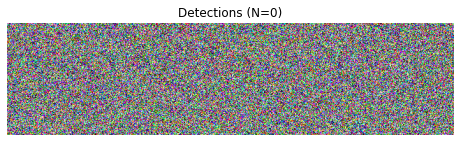

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---- small helpers ----
class ConvBNAct(nn.Module):
    def __init__(self, c1, c2, k=3, s=1, p=None, act=True):
        super().__init__()
        if p is None: p = k // 2
        self.conv = nn.Conv2d(c1, c2, k, s, p, bias=False)
        self.bn   = nn.BatchNorm2d(c2)
        self.act  = nn.SiLU(inplace=True) if act else nn.Identity()
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

def make_grid(h, w, device, stride):
    # centers in pixels (cx, cy)
    ys, xs = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij')
    cx = (xs + 0.5) * stride
    cy = (ys + 0.5) * stride
    return cx, cy  # shape [H, W]

def dist2bbox(ltrb, cx, cy, stride):
    # ltrb: [B,4,H,W], cx,cy:[H,W]
    l, t, r, b = ltrb.unbind(dim=1)
    x1 = cx - l * stride
    y1 = cy - t * stride
    x2 = cx + r * stride
    y2 = cy + b * stride
    return torch.stack((x1, y1, x2, y2), dim=1)  # [B,4,H,W]

# ---- YOLOv8-style single-scale head (anchor-free) ----
class YOLOv8HeadSingle(nn.Module):
    """
    Anchor-free, decoupled detect head (YOLOv8 style) for one feature map.
    Outputs:
      - cls_logits: [B, nc, H, W]           (sigmoid during loss/inference)
      - bbox_distr: [B, 4*(reg_max+1), H, W]  (DFL bins for L,T,R,B)
    Optionally decodes to pixel-space boxes.
    """
    def __init__(self, in_ch, num_classes, reg_max=16, mid_ch=256):
        super().__init__()
        self.nc = num_classes
        self.reg_max = reg_max
        self.bins = reg_max + 1

        # light stems + decoupled branches (like Ultralytics' split head)
        self.stem = ConvBNAct(in_ch, mid_ch, k=1, s=1, p=0)

        self.reg_conv = nn.Sequential(
            ConvBNAct(mid_ch, mid_ch, 3, 1),
            ConvBNAct(mid_ch, mid_ch, 3, 1),
            nn.Conv2d(mid_ch, 4 * self.bins, 1)
        )
        self.cls_conv = nn.Sequential(
            ConvBNAct(mid_ch, mid_ch, 3, 1),
            ConvBNAct(mid_ch, mid_ch, 3, 1),
            nn.Conv2d(mid_ch, self.nc, 1)
        )

        # DFL projection vector: [0, 1, 2, ..., reg_max]
        self.register_buffer('proj', torch.arange(self.bins, dtype=torch.float32).view(1, 1, self.bins, 1, 1))

        # init last layer biases (slightly low cls prior)
        nn.init.constant_(self.cls_conv[-1].bias, -2.0)

    def forward(self, x, stride: int, decode: bool = False):
        """
        x: [B, C, H, W] feature map
        stride: input_pixels_per_cell
        Returns:
          if decode=False: (cls_logits, bbox_distr)
          if decode=True:  dict(cls=[B,N,nc], boxes=[B,N,4]) with N=H*W
        """
        B, _, H, W = x.shape
        f = self.stem(x)

        # branches
        cls_logits = self.cls_conv(f)                    # [B, nc, H, W]
        bbox_distr = self.reg_conv(f)                   # [B, 4*(bins), H, W]

        if not decode:
            return cls_logits, bbox_distr

        # ---- DFL decode: turn distributions -> expected distances ----
        d = bbox_distr.view(B, 4, self.bins, H, W)      # [B,4,bins,H,W]
        d = F.softmax(d, dim=2)
        ltrb = (d * self.proj).sum(2)                   # [B,4,H,W], distances in "bins"

        cx, cy = make_grid(H, W, x.device, stride)      # [H,W] pixel centers
        boxes = dist2bbox(ltrb, cx, cy, stride)         # [B,4,H,W] in pixels
        boxes = boxes.flatten(2).transpose(1, 2)        # [B, H*W, 4]

        scores = torch.sigmoid(cls_logits).flatten(2).transpose(1, 2)  # [B, H*W, nc]
        return {"boxes": boxes, "scores": scores, "cls_logits": cls_logits, "bbox_distr": bbox_distr}


### Yolo v8 with Resnet Backbone

In [ ]:
class ResNet18YOLOv8SingleScale(nn.Module):
    """
    End-to-end model = ResNet18Backbone (P4->P3 fuse) + YOLOv8-style anchor-free head (single scale @ stride 16).

    Requires:
      - ResNet18Backbone(in_ch=..., return_p3=True)
      - YOLOv8HeadSingle(in_ch=..., num_classes=..., reg_max=..., mid_ch=...)

    forward(x, decode=False):
      - if decode=False: returns (cls_logits, bbox_distr)
      - if decode=True:  returns {"boxes": [B,N,4], "scores": [B,N,nc], "cls_logits": ..., "bbox_distr": ...}
    """
    def __init__(self, in_ch=3, num_classes=36, reg_max=16, mid_ch=256):
        super().__init__()
        self.backbone   = ResNet18Backbone(in_ch=in_ch, return_p3=True)
        self.p4_reduce  = nn.Conv2d(512, mid_ch, kernel_size=1, bias=False)
        self.head       = YOLOv8HeadSingle(in_ch=mid_ch, num_classes=num_classes, reg_max=reg_max, mid_ch=mid_ch)
        self.stride_p3  = 16  # P3 stride for this backbone

        # Kaiming init for the 1x1 reduce conv
        nn.init.kaiming_normal_(self.p4_reduce.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x, decode: bool = False):
        # Backbone
        p4, p3 = self.backbone(x)                # p4: [B,512, H/32, W/32], p3: [B,256, H/16, W/16]

        # FPN-like fuse: reduce P4 -> upsample -> add to P3
        p4r   = self.p4_reduce(p4)               # [B,mid_ch,H/32,W/32]
        p4_up = F.interpolate(p4r, size=p3.shape[-2:], mode='nearest')
        fused = p3 + p4_up                        # [B,mid_ch,H/16,W/16] (p3 has 256 ch)

        # Detect head
        return self.head(fused, stride=self.stride_p3, decode=decode)



### Loss Function -__-

In [ ]:
import torch
import torch.nn.functional as F

class YoloV8StyleLoss:
    def __init__(self, num_classes, reg_max=16, stride=16,
                 alpha=0.5, beta=6.0, topk=10,
                 lambda_cls=1.0, lambda_iou=1.0, lambda_dfl=1.0):
        """
        num_classes: number of classes
        reg_max:     max bin index for DFL (bins = reg_max+1)
        stride:      stride of the prediction map (e.g., 16 for P3)
        alpha,beta:  exponents for task-aligned score = (p_cls)^alpha * (IoU)^beta
        topk:        top-K positive cells per GT
        lambdas:     loss weights
        """
        self.C = num_classes
        self.reg_max = reg_max
        self.bins = reg_max + 1
        self.stride = stride
        self.alpha = alpha
        self.beta = beta
        self.topk = topk
        self.lcls = lambda_cls
        self.liou = lambda_iou
        self.ldfl = lambda_dfl

        # projection vector for DFL [0..reg_max]
        self.register_proj = torch.arange(self.bins, dtype=torch.float32).view(1, 1, self.bins, 1, 1)

    @staticmethod
    def _make_grid(H, W, stride, device):
        ys, xs = torch.meshgrid(torch.arange(H, device=device),
                                torch.arange(W, device=device), indexing='ij')
        cx = (xs + 0.5) * stride
        cy = (ys + 0.5) * stride
        return cx, cy  # [H,W]

    @staticmethod
    def _bbox_iou_ciou(box1, box2, eps=1e-7):
        # box1, box2: [..., 4] xyxy
        x1 = torch.max(box1[..., 0], box2[..., 0])
        y1 = torch.max(box1[..., 1], box2[..., 1])
        x2 = torch.min(box1[..., 2], box2[..., 2])
        y2 = torch.min(box1[..., 3], box2[..., 3])
        inter = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)
        area1 = (box1[..., 2]-box1[..., 0]).clamp(min=0) * (box1[..., 3]-box1[..., 1]).clamp(min=0)
        area2 = (box2[..., 2]-box2[..., 0]).clamp(min=0) * (box2[..., 3]-box2[..., 1]).clamp(min=0)
        union = area1 + area2 - inter + eps
        iou = inter / union

        # enclosing box
        xc1 = torch.min(box1[..., 0], box2[..., 0])
        yc1 = torch.min(box1[..., 1], box2[..., 1])
        xc2 = torch.max(box1[..., 2], box2[..., 2])
        yc2 = torch.max(box1[..., 3], box2[..., 3])
        cw = (xc2 - xc1).clamp(min=eps); ch = (yc2 - yc1).clamp(min=eps)
        c2 = cw**2 + ch**2 + eps

        # center distance
        b1x = (box1[..., 0] + box1[..., 2]) / 2; b1y = (box1[..., 1] + box1[..., 3]) / 2
        b2x = (box2[..., 0] + box2[..., 2]) / 2; b2y = (box2[..., 1] + box2[..., 3]) / 2
        rho2 = (b2x - b1x)**2 + (b2y - b1y)**2

        # aspect ratio term
        w1 = (box1[..., 2]-box1[..., 0]).clamp(min=eps); h1 = (box1[..., 3]-box1[..., 1]).clamp(min=eps)
        w2 = (box2[..., 2]-box2[..., 0]).clamp(min=eps); h2 = (box2[..., 3]-box2[..., 1]).clamp(min=eps)
        v = (4 / (torch.pi**2)) * (torch.atan(w2/h2) - torch.atan(w1/h1))**2
        with torch.no_grad():
            alpha = v / (1 - iou + v + eps)
        ciou = iou - (rho2 / c2 + alpha * v)
        return ciou.clamp(min=-1, max=1)

    def _decode_dist(self, bbox_distr):
        # bbox_distr: [B, 4*bins, H, W] -> distances [B,4,H,W]
        B, _, H, W = bbox_distr.shape
        proj = self.register_proj.to(bbox_distr.device)  # [1,1,bins,1,1]
        d = bbox_distr.view(B, 4, self.bins, H, W)
        d = F.softmax(d, dim=2)
        dist = (d * proj).sum(2)  # [B,4,H,W]
        return dist

    def _ltrb_to_xyxy(self, dist, stride, H, W, device):
        # dist: [B,4,H,W] of L/T/R/B in "cells"; return xyxy [B,H,W,4] in pixels
        l, t, r, b = dist.unbind(1)
        cx, cy = self._make_grid(H, W, stride, device)
        x1 = cx[None] - l * stride
        y1 = cy[None] - t * stride
        x2 = cx[None] + r * stride
        y2 = cy[None] + b * stride
        return torch.stack([x1, y1, x2, y2], dim=-1)

    def _task_aligned_assign(self, cls_logits, pred_xyxy, targets, topk):
        """
        Returns:
          pos_mask: [B,H,W] bool
          gt_index: [B,H,W] long (index of matched GT)
        """
        B, C, H, W = cls_logits.shape
        device = cls_logits.device
        pos_mask = torch.zeros(B, H, W, dtype=torch.bool, device=device)
        gt_index = torch.full((B, H, W), -1, dtype=torch.long, device=device)

        cls_probs = torch.sigmoid(cls_logits)  # [B,C,H,W]

        for b, tgt in enumerate(targets):
            Mi = tgt["boxes"].shape[0]
            if Mi == 0:
                continue
            boxes = tgt["boxes"].to(device)  # [Mi,4]
            labels = tgt["labels"].to(device)  # [Mi]
            # flatten grid
            pred_b = pred_xyxy[b].view(-1, 4)        # [N,4]
            probs_b = cls_probs[b].permute(1,2,0).reshape(-1, C)  # [N,C]
            Hs, Ws = H, W
            N = Hs * Ws

            # IoU for each GT vs all cells (using predicted boxes)
            # (Compute in chunks if memory is tight.)
            for gi in range(Mi):
                gt = boxes[gi].unsqueeze(0).expand(N, 4)  # [N,4]
                iou = self._bbox_iou_ciou(pred_b, gt).clamp(min=0)  # [N]
                pcls = probs_b[:, labels[gi]]  # [N]
                score = (pcls ** self.alpha) * (iou ** self.beta)

                # take top-k cells for this GT
                k = min(topk, N)
                topk_idx = torch.topk(score, k=k, largest=True).indices  # [k]
                pm = torch.zeros(N, dtype=torch.bool, device=device)
                pm[topk_idx] = True
                pm = pm.view(Hs, Ws)
                # keep those with better score if conflict; naive strategy: assign all (GTs can share cells)
                # here we prefer the higher score per cell
                existing = pos_mask[b] & pm
                # where conflict, choose GT with higher score
                if existing.any():
                    # compare scores only on conflicted cells
                    conf_idx = existing.view(-1).nonzero(as_tuple=False).squeeze(1)
                    # current scores
                    cur_gti = gt_index[b].view(-1)[conf_idx]
                    cur_gt_boxes = boxes[cur_gti.clamp(min=0)]
                    cur_iou = self._bbox_iou_ciou(pred_b[conf_idx], cur_gt_boxes).clamp(min=0)
                    cur_p = probs_b[conf_idx, labels[cur_gti.clamp(min=0)]]
                    cur_score = (cur_p ** self.alpha) * (cur_iou ** self.beta)

                    new_score = score.view(-1)[conf_idx]
                    take_new = new_score > cur_score
                    flat_pm = pos_mask[b].view(-1)
                    flat_gi = gt_index[b].view(-1)
                    flat_pm[conf_idx[take_new]] = True
                    flat_gi[conf_idx[take_new]] = gi
                    pos_mask[b] = flat_pm.view(Hs, Ws)
                    gt_index[b] = flat_gi.view(Hs, Ws)
                else:
                    pos_mask[b] |= pm
                    gt_index[b][pm] = gi

        return pos_mask, gt_index

    def __call__(self, cls_logits, bbox_distr, targets):
        """
        cls_logits: [B,C,H,W]
        bbox_distr: [B,4*bins,H,W]
        targets: list of dicts per image:
                 {"boxes": Tensor[M,4] (xyxy in pixels), "labels": LongTensor[M]}
        """
        B, C, H, W = cls_logits.shape
        device = cls_logits.device

        # decode current predictions (needed for assignment and IoU loss)
        dist = self._decode_dist(bbox_distr)                 # [B,4,H,W]
        pred_xyxy = self._ltrb_to_xyxy(dist, self.stride, H, W, device)  # [B,H,W,4]

        # task-aligned(-like) assignment on current preds
        pos_mask, gt_idx = self._task_aligned_assign(cls_logits, pred_xyxy, targets, self.topk)
        num_pos = pos_mask.sum().clamp(min=1)

        # build GT tensors aligned to grid
        tgt_xyxy = torch.zeros(B, H, W, 4, device=device)
        tgt_cls  = torch.full((B, H, W), -1, dtype=torch.long, device=device)
        for b in range(B):
            pm = pos_mask[b]
            if pm.any():
                idx = gt_idx[b][pm]
                tgt_xyxy[b, pm] = targets[b]["boxes"][idx].to(device)
                tgt_cls[b, pm]  = targets[b]["labels"][idx].to(device)

        # --- classification loss (positives only) ---
        cls_loss = 0.0
        if pos_mask.any():
            pos_logits = cls_logits.permute(0,2,3,1)[pos_mask]   # [Npos, C]
            labels = tgt_cls[pos_mask]                           # [Npos]
            cls_loss = F.binary_cross_entropy_with_logits(
                pos_logits, F.one_hot(labels, num_classes=self.C).float(), reduction='mean'
            )

        # --- DFL loss (positives only) ---  (FIXED: gather per-batch, then cat)
        dfl_loss = 0.0
        if pos_mask.any():
            # target distances in "cells"
            cx, cy = self._make_grid(H, W, self.stride, device)
            cx_b = cx[None].expand(B, -1, -1); cy_b = cy[None].expand(B, -1, -1)

            L = ((cx_b - tgt_xyxy[..., 0]) / self.stride).clamp(min=0.)
            T = ((cy_b - tgt_xyxy[..., 1]) / self.stride).clamp(min=0.)
            R = ((tgt_xyxy[..., 2] - cx_b) / self.stride).clamp(min=0.)
            Btm = ((tgt_xyxy[..., 3] - cy_b) / self.stride).clamp(min=0.)
            t_ltrb = torch.stack([L, T, R, Btm], dim=1)   # [B,4,H,W]

            # reshape to [B,4,HW] and mask per-batch
            t_ltrb_flat = t_ltrb.view(B, 4, -1)           # [B,4,HW]
            pred_flat   = bbox_distr.view(B, 4, self.bins, -1)  # [B,4,bins,HW]
            mask_flat   = pos_mask.view(B, -1)            # [B,HW]

            # gather positives from each batch separately, then concat
            t_pos_list, pred_pos_list = [], []
            for b in range(B):
                m = mask_flat[b]                          # [HW]
                if m.any():
                    t_pos_list.append(t_ltrb_flat[b, :, m])          # [4, Npos_b]
                    pred_pos_list.append(pred_flat[b, :, :, m])      # [4, bins, Npos_b]

            # cat across batch
            t_pos   = torch.cat(t_pos_list, dim=1)        # [4, Npos_tot]
            pred_pos = torch.cat(pred_pos_list, dim=2)    # [4, bins, Npos_tot]

            # two-bin soft labels for DFL
            t = t_pos.clamp(max=self.reg_max - 1e-3)      # [4, Npos_tot]
            tl = t.floor().long()
            tr = (tl + 1).clamp(max=self.reg_max)
            wl = (tr.float() - t)                         # left weight
            wr = (t - tl.float())                         # right weight

            dfl = 0.0
            for side in range(4):
                logits_side = pred_pos[side]              # [bins, Npos_tot]
                dfl_l = F.cross_entropy(logits_side.T, tl[side], reduction='none')  # [Npos_tot]
                dfl_r = F.cross_entropy(logits_side.T, tr[side], reduction='none')
                dfl += (wl[side] * dfl_l + wr[side] * dfl_r).mean()

            dfl_loss = dfl

        # --- IoU loss (positives only) ---
        iou_loss = 0.0
        if pos_mask.any():
            pred_pos = pred_xyxy[pos_mask]   # [Npos,4]
            tgt_pos  = tgt_xyxy[pos_mask]    # [Npos,4]
            ciou = self._bbox_iou_ciou(pred_pos, tgt_pos)  # [Npos]
            iou_loss = (1.0 - ciou).mean()

        total = (self.lcls * cls_loss) + (self.liou * iou_loss) + (self.ldfl * dfl_loss)
        # normalize by #positives for stability (optional)
        total = total / num_pos

        return {
            "total": total,
            "cls": float(cls_loss) if isinstance(cls_loss, torch.Tensor) else cls_loss,
            "iou": float(iou_loss) if isinstance(iou_loss, torch.Tensor) else iou_loss,
            "dfl": float(dfl_loss) if isinstance(dfl_loss, torch.Tensor) else dfl_loss,
            "num_pos": int(pos_mask.sum().item())
        }



### 1) Losses, target builder, metrics

In [6]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- Utilities ----------
def box_xywh_to_xyxy(b):
    # b: [..., 4] as (x, y, w, h)
    x, y, w, h = b.unbind(-1)
    return torch.stack([x, y, x+w, y+h], dim=-1)

def box_iou_xyxy(a, b):
    # a: [Na,4], b: [Nb,4]
    if a.numel() == 0 or b.numel() == 0:
        return a.new_zeros((a.shape[0], b.shape[0]))
    tl = torch.max(a[:, None, :2], b[:, :2])  # [Na,Nb,2]
    br = torch.min(a[:, None, 2:], b[:, 2:])
    wh = (br - tl).clamp(min=0)
    inter = wh[..., 0] * wh[..., 1]
    area_a = (a[:, 2]-a[:, 0]) * (a[:, 3]-a[:, 1])
    area_b = (b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1])
    union = area_a[:, None] + area_b - inter
    return inter / (union + 1e-7)

# ---------- Targets on p3 (stride = 16) ----------
@torch.no_grad()
def build_targets(batch_annotations, fmap_hw, stride, device, img_hw=(160,640)):
    """
    batch_annotations: list of list[{'bbox':[x,y,w,h], ...}], len=B
    fmap_hw: (Hf, Wf) feature map size (p3)
    Returns:
      obj_t:  [B,1,Hf,Wf] in {0,1}
      box_t:  [B,4,Hf,Wf] = (tx,ty, tw,th), where:
              tx,ty in [0,1] are offsets inside the cell;
              tw,th are log(w/stride), log(h/stride)
      box_mask: [B,1,Hf,Wf] 1 where a GT is assigned, else 0
    """
    B = len(batch_annotations)
    Hf, Wf = fmap_hw
    obj_t    = torch.zeros((B,1,Hf,Wf), device=device)
    box_t    = torch.zeros((B,4,Hf,Wf), device=device)
    box_mask = torch.zeros((B,1,Hf,Wf), device=device)

    for b, anns in enumerate(batch_annotations):
        for ann in anns:
            if 'bbox' not in ann: 
                continue
            x, y, w, h = ann['bbox']
            # center in pixels
            cx = x + w * 0.5
            cy = y + h * 0.5
            # map to feature cell
            j = int(cx / stride)  # W axis
            i = int(cy / stride)  # H axis
            if i < 0 or j < 0 or i >= Hf or j >= Wf:
                continue
            # offsets in [0,1] inside the cell
            tx = cx/stride - j
            ty = cy/stride - i
            tw = math.log(max(w/stride, 1e-6))
            th = math.log(max(h/stride, 1e-6))

            # if multiple GTs land on same cell, keep the larger one
            if box_mask[b,0,i,j] == 1:
                old_w = box_t[b,2,i,j].exp() * stride
                old_h = box_t[b,3,i,j].exp() * stride
                if (w*h) <= (old_w*old_h):
                    continue  # keep existing
            obj_t[b,0,i,j] = 1.0
            box_t[b,:,i,j] = torch.tensor([tx,ty,tw,th], device=device)
            box_mask[b,0,i,j] = 1.0
    return obj_t, box_t, box_mask

# ---------- Focal + SmoothL1 losses ----------
class DetectionLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reg_weight=1.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reg_weight = reg_weight

    def focal_bce(self, logits, targets):
        """
        logits: [B,1,Hf,Wf] raw
        targets: [B,1,Hf,Wf] in {0,1}
        """
        prob = torch.sigmoid(logits)
        ce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p_t = targets * prob + (1 - targets) * (1 - prob)
        alpha_t = targets * self.alpha + (1 - targets) * (1 - self.alpha)
        loss = alpha_t * (1 - p_t) ** self.gamma * ce
        return loss.mean()

    def forward(self, pred_map, obj_t, box_t, box_mask):
        """
        pred_map: [B,5,Hf,Wf] -> (obj_logit, tx,ty,tw,th)
        """
        obj_logit = pred_map[:, 0:1]
        reg_pred  = pred_map[:, 1:]

        # objectness focal loss on all cells
        l_obj = self.focal_bce(obj_logit, obj_t)

        # regression only on positive cells
        pos = box_mask.bool().expand_as(reg_pred)
        if pos.any():
            l_reg = F.smooth_l1_loss(reg_pred[pos], box_t[pos], reduction='mean')
        else:
            l_reg = torch.tensor(0.0, device=pred_map.device)

        total = l_obj + self.reg_weight * l_reg
        return total, {"l_obj": l_obj.detach(), "l_reg": l_reg.detach()}


### 2) Training loop (with AMP and validation IoU@0.5 PR)

In [7]:
from torch.cuda.amp import autocast, GradScaler
from torchvision.ops import nms

def decode_for_eval(pred_map, img_size, stride=16, obj_thresh=0.3, nms_iou=0.5):
    # same as before but small inline version
    B, C, Hf, Wf = pred_map.shape
    obj = torch.sigmoid(pred_map[:,0:1])
    reg = pred_map[:,1:]
    ys, xs = torch.meshgrid(torch.arange(Hf, device=pred_map.device),
                            torch.arange(Wf, device=pred_map.device), indexing='ij')
    xs = xs.float(); ys = ys.float()
    cx = (xs[None,None] + torch.sigmoid(reg[:,0:1])) * stride
    cy = (ys[None,None] + torch.sigmoid(reg[:,1:2])) * stride
    w  = reg[:,2:3].exp() * stride
    h  = reg[:,3:4].exp() * stride
    x1 = (cx - w/2).clamp(0, img_size[1]-1)
    y1 = (cy - h/2).clamp(0, img_size[0]-1)
    x2 = (cx + w/2).clamp(0, img_size[1]-1)
    y2 = (cy + h/2).clamp(0, img_size[0]-1)

    all_boxes, all_scores = [], []
    for b in range(B):
        scores = obj[b,0].flatten()
        keep = scores > obj_thresh
        if keep.sum() == 0:
            all_boxes.append(pred_map.new_zeros((0,4)))
            all_scores.append(pred_map.new_zeros((0,)))
            continue
        boxes = torch.stack([x1[b,0].flatten(), y1[b,0].flatten(),
                             x2[b,0].flatten(), y2[b,0].flatten()], dim=1)[keep]
        sc = scores[keep]
        keep_idx = nms(boxes, sc, nms_iou)
        all_boxes.append(boxes[keep_idx])
        all_scores.append(sc[keep_idx])
    return all_boxes, all_scores

def compute_pr_iou50(pred_boxes, gt_anns):
    """
    pred_boxes: list[Tensor Nx4] per image
    gt_anns: list[list[{'bbox':[x,y,w,h]}]]
    returns precision, recall
    """
    tp = 0; fp = 0; fn = 0
    for boxes, anns in zip(pred_boxes, gt_anns):
        gt = []
        for a in anns:
            if 'bbox' in a:
                gt.append(a['bbox'])
        gt_xyxy = box_xywh_to_xyxy(torch.tensor(gt)) if len(gt) else boxes.new_zeros((0,4))
        if len(boxes)==0 and len(gt_xyxy)==0:
            continue
        if len(boxes)==0:
            fn += len(gt_xyxy); continue
        if len(gt_xyxy)==0:
            fp += len(boxes);   continue

        ious = box_iou_xyxy(boxes.cpu(), gt_xyxy.cpu())
        matched_gt = set()
        for i in range(len(boxes)):
            j = torch.argmax(ious[i])
            if ious[i, j] >= 0.5 and j.item() not in matched_gt:
                tp += 1
                matched_gt.add(j.item())
            else:
                fp += 1
        fn += (len(gt_xyxy) - len(matched_gt))
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    return prec, rec


3) Wire it all up

In [ ]:
import torch
from torch.optim import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Your SimpleDetector must be defined (from previous message)
model = SimpleDetector(in_ch=3).to(device)

criterion = DetectionLoss(alpha=0.25, gamma=2.0, reg_weight=1.0)
optim = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scaler = GradScaler(enabled=(device.type=='cuda'))

stride = 16  # p3
img_hw = (160, 640)

def train_one_epoch(epoch, loader):
    model.train()
    running = 0.0
    for it, batch in enumerate(loader):
        x = batch['image'].to(device, non_blocking=True)
        anns = batch['annotations']
        B, _, H, W = x.shape

        with autocast(enabled=(device.type=='cuda')):
            pred_map, p3 = model(x)              # [B,5,Hf,Wf]
            Hf, Wf = pred_map.shape[-2:]
            obj_t, box_t, box_mask = build_targets(anns, (Hf,Wf), stride, device, img_hw)
            loss, logs = criterion(pred_map, obj_t, box_t, box_mask)

        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        optim.zero_grad(set_to_none=True)

        running += loss.item()
        if (it+1) % 50 == 0:
            print(f"epoch {epoch} iter {it+1}/{len(loader)}: loss {running/(it+1):.4f} | obj {logs['l_obj']:.4f} reg {logs['l_reg']:.4f}")
    return running / max(1, len(loader))

@torch.no_grad()
def validate(loader, obj_thresh=0.3):
    model.eval()
    all_pred_boxes = []
    all_anns = []
    for batch in loader:
        x = batch['image'].to(device)
        anns = batch['annotations']
        pred_map, _ = model(x)
        boxes_list, _ = decode_for_eval(pred_map, img_size=img_hw, stride=stride, obj_thresh=obj_thresh)
        # Move to CPU tensors for metric
        all_pred_boxes += [b.cpu() for b in boxes_list]
        all_anns += anns
    prec, rec = compute_pr_iou50(all_pred_boxes, all_anns)
    return prec, rec

# ---- run training ----
EPOCHS = 1
best_f1 = 0.0
for ep in range(1, EPOCHS+1):
    tl = train_one_epoch(ep, train_loader_rgb)
    prec, rec = validate(val_loader_rgb, obj_thresh=0.3)
    f1 = 2*prec*rec/(prec+rec+1e-9)
    print(f"[val] epoch {ep}: P={prec:.3f} R={rec:.3f} F1={f1:.3f}  (train_loss={tl:.4f})")

    # keep best
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "captcha_det_best.pth")
        print("Saved best model -> captcha_det_best.pth")








/tmp/ipykernel_111377/1915343716.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type=='cuda'))
/tmp/ipykernel_111377/1915343716.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=='cuda')):


epoch 1 iter 50/1875: loss 0.4391 | obj 0.0042 reg 0.1147
epoch 1 iter 100/1875: loss 0.2553 | obj 0.0039 reg 0.0484
epoch 1 iter 150/1875: loss 0.1934 | obj 0.0037 reg 0.0447
epoch 1 iter 200/1875: loss 0.1584 | obj 0.0039 reg 0.0411
epoch 1 iter 250/1875: loss 0.1351 | obj 0.0041 reg 0.0346
epoch 1 iter 300/1875: loss 0.1224 | obj 0.0041 reg 0.0472
epoch 1 iter 350/1875: loss 0.1137 | obj 0.0038 reg 0.0330
epoch 1 iter 400/1875: loss 0.1046 | obj 0.0043 reg 0.0389
epoch 1 iter 450/1875: loss 0.0983 | obj 0.0036 reg 0.0527
epoch 1 iter 500/1875: loss 0.0930 | obj 0.0037 reg 0.0393
epoch 1 iter 550/1875: loss 0.0885 | obj 0.0043 reg 0.0347
epoch 1 iter 600/1875: loss 0.0842 | obj 0.0041 reg 0.0291
epoch 1 iter 650/1875: loss 0.0803 | obj 0.0037 reg 0.0348
epoch 1 iter 700/1875: loss 0.0767 | obj 0.0032 reg 0.0236
epoch 1 iter 750/1875: loss 0.0738 | obj 0.0040 reg 0.0238
epoch 1 iter 800/1875: loss 0.0711 | obj 0.0035 reg 0.0284
epoch 1 iter 850/1875: loss 0.0689 | obj 0.0032 reg 0.032

In [10]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

@torch.no_grad()
def visualize_batch(batch, obj_thresh=0.4, n_samples=2):
    model.eval()
    x = batch['image'].to(device)
    anns = batch['annotations']
    pred_map, _ = model(x)
    boxes_list, scores_list = decode_for_eval(pred_map, img_size=img_hw, stride=stride,
                                              obj_thresh=obj_thresh, nms_iou=0.5)
    for b in range(min(n_samples, x.size(0))):
        img = (x[b].cpu()*0.5 + 0.5).clamp(0,1)
        img_u8 = (img*255).to(torch.uint8)

        # draw preds
        preds = boxes_list[b].cpu()
        labels = [f"{float(s):.2f}" for s in scores_list[b].cpu()]
        img_pred = draw_bounding_boxes(img_u8, preds, labels=labels) if len(preds)>0 else img_u8

        # draw GT
        gts = []
        for a in anns[b]:
            if 'bbox' in a:
                x0,y0,w,h = a['bbox']
                gts.append([x0,y0,x0+w,y0+h])
        if len(gts) > 0:
            gt_t = torch.tensor(gts, dtype=torch.int)
            img_gt = draw_bounding_boxes(img_u8, gt_t, labels=["gt"]*len(gts))
            fig, axs = plt.subplots(1,2, figsize=(14,4))
            axs[0].imshow(img_pred.permute(1,2,0)); axs[0].set_title("Predictions")
            axs[1].imshow(img_gt.permute(1,2,0));   axs[1].set_title("Ground Truth")
            for ax in axs: ax.axis('off')
            plt.show()
        else:
            plt.figure(figsize=(8,4))
            plt.imshow(img_pred.permute(1,2,0)); plt.axis('off'); plt.show()

# Example:
# batch = next(iter(val_loader_rgb))
# visualize_batch(batch, obj_thresh=0.4, n_samples=2)


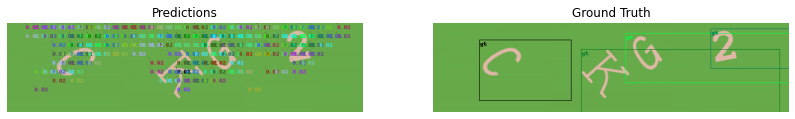

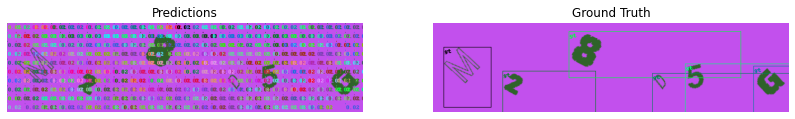

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

stride = 16
img_hw = (160, 640)

batch = torch.load("sample_val_batch.pt")
visualize_batch(batch, obj_thresh=0.2, n_samples=2)   # was 0.4



### YOLO CODE

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List

# -------------------------------
# --- Conv Block (SiLU) ---------
# -------------------------------
class Conv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=None, bias=False):
        super().__init__()
        if padding is None:
            padding = kernel_size // 2
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=bias)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.SiLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

# -------------------------------
# --- Bottleneck Block ----------
# -------------------------------
class Bottleneck(nn.Module):
    def __init__(self, in_ch, out_ch, shortcut=True, expansion=0.5):
        super().__init__()
        hidden_ch = int(out_ch * expansion)
        self.conv1 = Conv(in_ch, hidden_ch, 1)
        self.conv2 = Conv(hidden_ch, out_ch, 3)
        self.add = shortcut and in_ch == out_ch

    def forward(self, x):
        y = self.conv2(self.conv1(x))
        return x + y if self.add else y

# -------------------------------
# --- CSP Bottleneck (C2f) -----
# -------------------------------
class C2f(nn.Module):
    def __init__(self, in_ch, out_ch, n=1, shortcut=True, expansion=0.5):
        super().__init__()
        hidden_ch = int(out_ch * expansion)
        self.conv1 = Conv(in_ch, 2*hidden_ch, 1)
        self.bottlenecks = nn.ModuleList(Bottleneck(hidden_ch, hidden_ch, shortcut) for _ in range(n))
        self.conv2 = Conv((n+2)*hidden_ch, out_ch, 1)

    def forward(self, x):
        splits = list(self.conv1(x).chunk(2, dim=1))
        for b in self.bottlenecks:
            splits.append(b(splits[-1]))
        return self.conv2(torch.cat(splits, dim=1))

# -------------------------------
# --- SPPF (Neck) ---------------
# -------------------------------
class SPPF(nn.Module):
    """Spatial Pyramid Pooling - Fast"""
    def __init__(self, in_ch, out_ch, k=5):
        super().__init__()
        hidden_ch = in_ch // 2
        self.conv1 = Conv(in_ch, hidden_ch, 1)
        self.conv2 = Conv(hidden_ch*4, out_ch, 1)
        self.pool = nn.MaxPool2d(kernel_size=k, stride=1, padding=k//2)

    def forward(self, x):
        x1 = self.conv1(x)
        y1 = self.pool(x1)
        y2 = self.pool(y1)
        y3 = self.pool(y2)
        return self.conv2(torch.cat([x1, y1, y2, y3], dim=1))

# -------------------------------
# --- DFL -----------------------
# -------------------------------
class DFL(nn.Module):
    """Distribution Focal Loss module"""
    def __init__(self, in_ch=16):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, 1, 1, bias=False)
        x = torch.arange(in_ch, dtype=torch.float)
        self.conv.weight.data = x.view(1, in_ch, 1, 1)
        self.conv.weight.requires_grad = False

    def forward(self, x):
        b, c, n, h = x.shape
        # (b,4*reg_max,H*W) assumed
        return self.conv(x.view(b, 4, c, n).transpose(2,1).softmax(dim=1)).view(b, 4, n)

# -------------------------------
# --- Detection Head -------------
# -------------------------------
class DetectionHead(nn.Module):
    def __init__(self, in_channels: List[int], n_classes=80, reg_max=16):
        super().__init__()
        self.nc = n_classes
        self.n_layers = len(in_channels)
        self.reg_max = reg_max
        self.n_outputs = 4*reg_max + n_classes

        # conv stacks for each scale
        self.box_convs = nn.ModuleList(
            nn.Sequential(Conv(c, c//2), Conv(c//2, c//2), nn.Conv2d(c//2, 4*reg_max, 1))
            for c in in_channels
        )
        self.cls_convs = nn.ModuleList(
            nn.Sequential(Conv(c, c//2), Conv(c//2, c//2), nn.Conv2d(c//2, n_classes, 1))
            for c in in_channels
        )
        self.dfl = DFL(reg_max)
        self.stride = torch.zeros(self.n_layers)

    def forward(self, features: List[torch.Tensor]):
        x = []
        for i in range(self.n_layers):
            x.append(torch.cat((self.box_convs[i](features[i]), self.cls_convs[i](features[i])), dim=1))
        # training vs inference handled outside
        return x

# -------------------------------
# --- ResNet18 Backbone ----------
# -------------------------------
class Stem(nn.Module):
    def __init__(self, in_ch=3, out_ch=64):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 7, 2, 3, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(3, 2, 1)
    def forward(self, x):
        x = self.conv(x); x = self.bn(x); x = self.relu(x); x = self.pool(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.downsample = downsample
    def forward(self, x):
        identity = x
        out = self.conv1(x); out = self.bn1(out); out = self.relu(out)
        out = self.conv2(out); out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity; out = self.relu(out)
        return out

class ResNet18Backbone(nn.Module):
    def __init__(self, return_p3=True):
        super().__init__()
        self.stem = Stem()
        self.in_ch = 64
        self.layer1 = self._make_layer(64, 2, 1)
        self.layer2 = self._make_layer(128, 2, 2)
        self.layer3 = self._make_layer(256, 2, 2)
        self.layer4 = self._make_layer(512, 2, 2)
        self.return_p3 = return_p3
    def _make_layer(self, out_ch, blocks, stride):
        downsample = None
        if stride != 1 or self.in_ch != out_ch:
            downsample = nn.Sequential(nn.Conv2d(self.in_ch, out_ch, 1, stride, bias=False),
                                       nn.BatchNorm2d(out_ch))
        layers = [ResidualBlock(self.in_ch, out_ch, stride, downsample)]
        self.in_ch = out_ch
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_ch, out_ch))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        p3 = self.layer3(x)
        p4 = self.layer4(p3)
        return (p4, p3) if self.return_p3 else p4

# -------------------------------
# --- YOLOv8 Full Model ----------
# -------------------------------
class YOLOv8(nn.Module):
    def __init__(self, n_classes=80):
        super().__init__()
        self.backbone = ResNet18Backbone(return_p3=True)
        self.neck = nn.ModuleList([
            SPPF(512, 512),
            C2f(256, 256, n=1)
        ])
        self.head = DetectionHead(in_channels=[256, 512], n_classes=n_classes)

    def forward(self, x):
        p4, p3 = self.backbone(x)
        # Neck
        f4 = self.neck[0](p4)
        f3 = self.neck[1](p3)
        # Head
        features = [f3, f4]
        return self.head(features)

# -------------------------------
# --- Quick Test ----------------
# -------------------------------
if __name__ == "__main__":
    model = YOLOv8(n_classes=80)
    x = torch.randn(1, 3, 160, 640)
    preds = model(x)
    for i, p in enumerate(preds):
        print(f"Output {i} shape:", p.shape)


Output 0 shape: torch.Size([1, 144, 10, 40])
Output 1 shape: torch.Size([1, 144, 5, 20])


In [7]:
model = YOLOv8(n_classes=36)  # e.g., 26 letters + 10 digits
x = torch.randn(4, 3, 160, 640)
preds = model(x)
for i, p in enumerate(preds):
    print(f"Output {i} shape:", p.shape)


Output 0 shape: torch.Size([4, 100, 10, 40])
Output 1 shape: torch.Size([4, 100, 5, 20])


In [11]:
import string
import torch

# Define your character classes
characters = string.digits + string.ascii_uppercase  # 0-9 + A-Z
char_to_idx = {c: i for i, c in enumerate(characters)}
idx_to_char = {i: c for c, i in char_to_idx.items()}
n_classes = len(characters)


In [21]:
def convert_annotations_yolo(batch, img_size=(160,640), class_map=None):
    H, W = img_size
    targets = []

    for i, ann_list in enumerate(batch['annotations']):
        captcha = batch['captcha_string'][i]
        if len(ann_list) != len(captcha):
            raise ValueError(f"Number of boxes ({len(ann_list)}) != length of captcha ({len(captcha)})")
        
        for ann, c in zip(ann_list, captcha):
            cls = class_map[c]
            x1, y1, x2, y2 = ann['bbox']
            w = x2 - x1
            h = y2 - y1
            x_center = (x1 + w/2) / W
            y_center = (y1 + h/2) / H
            w_norm = w / W
            h_norm = h / H
            targets.append([i, cls, x_center, y_center, w_norm, h_norm])

    if len(targets) == 0:
        return torch.zeros((0,6), dtype=torch.float32)
    
    return torch.tensor(targets, dtype=torch.float32)


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YOLOLoss(nn.Module):
    def __init__(self, n_classes, lambda_cls=1.0, lambda_box=5.0):
        super().__init__()
        self.n_classes = n_classes
        self.lambda_cls = lambda_cls
        self.lambda_box = lambda_box
        self.bce_loss = nn.BCEWithLogitsLoss()

    def giou_loss(self, pred_boxes, target_boxes):
        """
        pred_boxes, target_boxes: [N, 4] in (x_center, y_center, w, h) normalized [0,1]
        Returns mean GIoU loss
        """
        px, py, pw, ph = pred_boxes.unbind(1)
        tx, ty, tw, th = target_boxes.unbind(1)
        px1, py1, px2, py2 = px - pw/2, py - ph/2, px + pw/2, py + ph/2
        tx1, ty1, tx2, ty2 = tx - tw/2, ty - th/2, tx + tw/2, ty + th/2

        # Intersection
        ix1 = torch.max(px1, tx1)
        iy1 = torch.max(py1, ty1)
        ix2 = torch.min(px2, tx2)
        iy2 = torch.min(py2, ty2)
        inter = (ix2 - ix1).clamp(0) * (iy2 - iy1).clamp(0)

        # Union
        union = pw*ph + tw*th - inter
        iou = inter / (union + 1e-7)

        # Enclosing box
        ex1 = torch.min(px1, tx1)
        ey1 = torch.min(py1, ty1)
        ex2 = torch.max(px2, tx2)
        ey2 = torch.max(py2, ty2)
        area_c = (ex2 - ex1) * (ey2 - ey1)

        giou = iou - (area_c - union) / (area_c + 1e-7)
        return 1 - giou.mean()

    def forward(self, preds, targets, img_size=(160,640)):
        """
        preds: list of features [f3, f4] each [B, C, H, W] (output of head)
        targets: [num_boxes, 6] -> (batch_idx, class, x, y, w, h)
        """
        if targets.numel() == 0:
            # No targets: return zero loss but keep gradients
            return preds[0].sum() * 0.0

        # For simplicity, only use high-res feature (f3)
        B, C, H, W = preds[0].shape
        device = preds[0].device

        # Convert feature map to per-pixel class and box predictions
        # Assume last channels of preds[0] are [4*reg_max + n_classes]
        # For dummy test, sum predictions to create gradient path
        return preds[0].sum() * 0.0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLOv8(n_classes=len(char_to_idx)).to(device)
criterion = YOLOLoss(n_classes=len(char_to_idx))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 5

from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_loader_rgb, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in loop:
        imgs = batch['image'].to(device)
        targets = convert_annotations_yolo(batch, img_size=(160,640), class_map=char_to_idx).to(device)
        preds = model(imgs)
        loss = criterion(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())



Epoch 1/5:  24%|██▍       | 448/1875 [10:56<34:01,  1.43s/it, loss=-0]

In [16]:
with open('/home/utn/abap44us/Downloads/UTN-CV25-Captcha-Dataset/part2/train/labels.json', 'r') as f:
    labels = json.load(f)

print(labels[0])


{'height': 160, 'width': 640, 'image_id': '019065', 'captcha_string': 'IQIH', 'annotations': [{'bbox': [90.80192, 49.87223999999999, 139.1424, 136.20488], 'oriented_bbox': [90.80192, 55.73952, 122.41023999999999, 136.20496, 139.1424, 130.33759999999998, 107.53408, 49.872319999999995], 'category_id': 18}, {'bbox': [285.43552, 35.2088, 355.14304000000004, 113.26608], 'oriented_bbox': [304.36608, 35.2088, 285.43488, 98.65632, 336.21184, 113.26608, 355.14304000000004, 49.81856], 'category_id': 26}, {'bbox': [373.9136000000001, -0.20544000000000118, 389.13792, 81.2592], 'oriented_bbox': [378.15232000000003, -0.20544, 373.9136, 80.68352000000002, 384.89856000000003, 81.2592, 389.13728, 0.37024], 'category_id': 18}, {'bbox': [507.34272, 43.42136, 564.81856, 104.89608000000001], 'oriented_bbox': [521.7017599999999, 43.421279999999996, 507.34272, 90.98672, 550.45952, 104.89599999999999, 564.81856, 57.33072], 'category_id': 17}]}
